In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from imblearn.over_sampling import SMOTE

In [2]:
# 1. Memuat Data
data = pd.read_csv('dataset/Train.csv')

In [3]:
# 2. Eksplorasi Data
print("Informasi Data:")
print(data.info())


Informasi Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB
None


In [4]:
print("\nLima Baris Pertama Data:")
print(data.head())


Lima Baris Pertama Data:
   ID Warehouse_block Mode_of_Shipment  Customer_care_calls  Customer_rating  \
0   1               D           Flight                    4                2   
1   2               F           Flight                    4                5   
2   3               A           Flight                    2                2   
3   4               B           Flight                    3                3   
4   5               C           Flight                    2                2   

   Cost_of_the_Product  Prior_purchases Product_importance Gender  \
0                  177                3                low      F   
1                  216                2                low      M   
2                  183                4                low      M   
3                  176                4             medium      M   
4                  184                3             medium      F   

   Discount_offered  Weight_in_gms  Reached.on.Time_Y.N  
0                44 

In [5]:
# Memeriksa distribusi variabel target
print("\nDistribusi Variabel Target:")
print(data['Reached.on.Time_Y.N'].value_counts(normalize=True))


Distribusi Variabel Target:
Reached.on.Time_Y.N
1    0.596691
0    0.403309
Name: proportion, dtype: float64


In [6]:
# Menghapus kolom ID karena tidak relevan
data = data.drop('ID', axis=1)

In [7]:
# Mengonversi variabel kategori menjadi numerik menggunakan LabelEncoder
label_cols = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']
label_encoders = {col: LabelEncoder().fit(data[col]) for col in label_cols}
for col in label_cols:
    data[col] = label_encoders[col].transform(data[col])

In [8]:
# Pisahkan fitur dan target
X = data.drop('Reached.on.Time_Y.N', axis=1)
y = data['Reached.on.Time_Y.N']

In [9]:
# Normalisasi fitur numerik
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# Menyeimbangkan data dengan SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

In [11]:
# Split dataset menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

In [12]:
# Inisialisasi model XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)

In [13]:
# Set hyperparameter yang ingin diuji
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

In [14]:
# Grid Search untuk hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='roc_auc', verbose=2)

In [15]:
# Mendapatkan model terbaik dan menampilkan hyperparameters terbaik
best_model = grid_search.best_estimator_
print("Hyperparameters terbaik:", grid_search.best_params_)

Hyperparameters terbaik: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.9}


In [16]:
# Menggunakan model terbaik untuk prediksi pada test set
y_pred_best = best_model.predict(X_test)

In [17]:
# Evaluasi model terbaik
print("\nConfusion Matrix - XGBoost:")
print(confusion_matrix(y_test, y_pred_best))

print("\nClassification Report - XGBoost:")
print(classification_report(y_test, y_pred_best))

print("\nAccuracy Score - XGBoost:", accuracy_score(y_test, y_pred_best))
print("ROC AUC Score - XGBoost:", roc_auc_score(y_test, y_pred_best))


Confusion Matrix - XGBoost:
[[1183  130]
 [ 594  719]]

Classification Report - XGBoost:
              precision    recall  f1-score   support

           0       0.67      0.90      0.77      1313
           1       0.85      0.55      0.67      1313

    accuracy                           0.72      2626
   macro avg       0.76      0.72      0.72      2626
weighted avg       0.76      0.72      0.72      2626


Accuracy Score - XGBoost: 0.7242955064737243
ROC AUC Score - XGBoost: 0.7242955064737242


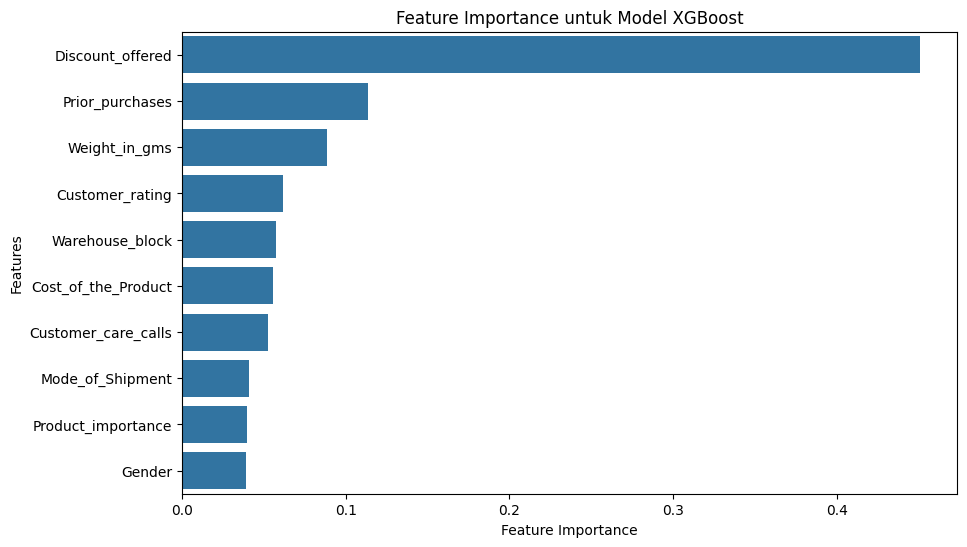

In [18]:
# 7. Visualisasi Feature Importance
feature_importance = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance untuk Model XGBoost')
plt.show()